<a href="https://colab.research.google.com/github/mezaga/ACIML-prototype/blob/main/ACIML_prototype_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ACIML Prototipo** 🔊🔊

¡Hola!

Muchas gracias por tomarte el tiempo de participar en este estudio. ACIML es un prototipo que permite entrenar un modelo de inteligencia artificial generativo de manera interactiva con señales digitales. Una vez terminado el entrenamiento, es posible crear nuevos sonidos a partir de los sonidos aprendidos.

Para esto es importante tomar las siguientes etapas en cuenta:

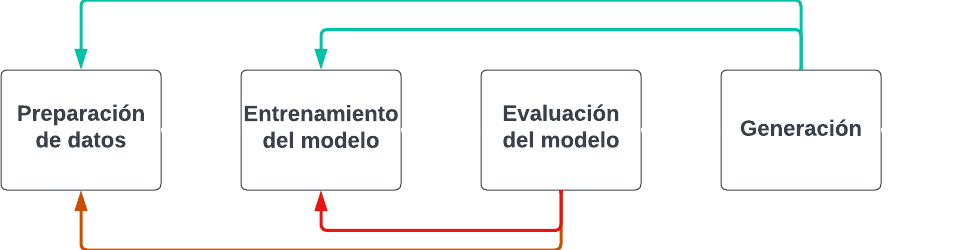


**Gerardo Meza, Tecnología Musical, UNAM**
info:
---

DESCARGA DE AUDIOS:
https://drive.google.com/file/d/1KW_QrFYsts3ccMv222hJsOLWHKCPdCb_/view?usp=sharing


In [1]:
#@title Carga de Librerias
##@markdown *Solo evalúa una vez esta celda*
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1P--SbiazyeD_m3Nxhuz331knZ2B-iWZO' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1P--SbiazyeD_m3Nxhuz331knZ2B-iWZO" -O encoder2_cdmx.zip && rm -rf /tmp/cookies.txt
!unzip /content/encoder2_cdmx.zip
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=169SFhtDzPuoM0d5YzIdRVjx3C-8dSB7o' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=169SFhtDzPuoM0d5YzIdRVjx3C-8dSB7o" -O decoder2_cdmx.zip && rm -rf /tmp/cookies.txt
!unzip /content/decoder2_cdmx.zip

!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1egipBGfxnvWiDE4C0wgr2uO2-xfK3t3R' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1egipBGfxnvWiDE4C0wgr2uO2-xfK3t3R" -O vanilla_encoder.zip && rm -rf /tmp/cookies.txt
!unzip /content/vanilla_encoder.zip
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=12XmcSvVEsn3Fdg-SoCGxQGZdKQTSHeDU' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=12XmcSvVEsn3Fdg-SoCGxQGZdKQTSHeDU" -O vanilla_decoder.zip && rm -rf /tmp/cookies.txt
!unzip /content/vanilla_decoder.zip
!pip install ffmpeg-python
from scipy.signal import butter, filtfilt
from scipy import signal
import math
from scipy.signal import butter, sosfilt, sosfreqz
from sklearn.preprocessing import StandardScaler
from ipywidgets import HBox, VBox, Output
import ipywidgets as widgets
from ipywidgets import TwoByTwoLayout
from ipywidgets import interact, interactive, fixed, interact_manual
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import IPython
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras import layers
from keras.models import Model
from keras import backend as K
from sklearn.decomposition import  PCA
from mpl_toolkits.mplot3d import Axes3D
import IPython
import pickle
import pandas as pd
import random
sr16k = 16000
AUDIO_LOAD = []
etiquetas = []
track_num = []

def zero_padding(array, padding = 2048):
  shape = np.shape(array)
  padded_array = np.zeros((padding))
  padded_array[:shape[0]] = array
  return padded_array

def normalize_sum(values):
  env_val = np.array([x.value for x in values])
  env_val = env_val/ env_val.min()
  env_val = env_val/env_val.sum()
  return env_val
  
def sinusoid(freq=440.0, dur=1.0, srate=16000, amp=1.0, phase = 0.0): 
    t = np.linspace(0,dur,int(srate*dur))
    data = amp * np.sin(2*np.pi*freq *t+phase)
    return data

def envelope(atk,dcy,rel, durs, sr):
 env = np.concatenate((np.linspace(0,atk,int(durs[0]* sr//1)), #atk
                       np.linspace(atk, dcy, int(durs[1]* sr//1)), #dcy
                       np.linspace(dcy, dcy, int(durs[2]* sr//1)), #sus
                       np.linspace(dcy,0, int(durs[3]* sr//1))),axis = None) #rel
 if env.shape[0] < sr:
   env = np.concatenate((env,np.zeros(sr - env.shape[0])))
 return env

class SynthGen:
  """This class returns a synth"""
  #atributes
  def __init__(self, sr , envelope):
    self.sr = sr
    #self.osc = osc
    self.env = envelope
    
   ######aun hay que arreglar que carge la carga de la señal 
   
  def sinusoid(self, freq = 100, dur=1.0, amp= 1.0, phase = 0.0): 
    t = np.linspace(0,dur,int( self.sr * dur))
    osc = amp * np.sin(2*np.pi* freq * t + phase)
    return osc

  def am(self, c_freq= 100.0, m_freq = 10.0, dur = 1):
    sig = sinusoid(c_freq,dur) * sinusoid(m_freq, dur)
    return sig * self.env

  def fm(self, freq = 440, c_ratio = 1, mod_ratio = 1, index_mod = 3, dur = 1):
    carrier = sinusoid(freq * c_ratio, dur, 1)
    mod = index_mod * sinusoid(freq * mod_ratio, dur)
    sig = np.cos(carrier + mod)
    return sig * self.env
 
   
  def additive(self, freq = 100, harms = 3, dur = 1):
     i = 1
     t = np.linspace(0, dur, math.ceil(self.sr * dur))
    ### initialize a new output
     sig = np.zeros(t.size)
     for harm in range(harms):
       if i == 0:
         x = np.multiply(sinusoid(freq * harm, dur),0.5)
         sig = sig + x
         i+=1
       else:
         x = np.multiply(sinusoid(freq * harm, dur), np.random.rand(1)[0])
         sig = sig + x
         i+=1
      
    ### making sure the maximum amplitude does not exeed 1
     if np.max(sig)>abs(np.min(sig)):
        sig = sig / np.max(sig)
     else:
        sig = sig / -np.min(sig)
     return sig * self.env  
  
  def sustractive(self, lowcut= 800, highcut = 1000):
    
    def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

    def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
            sos = butter_bandpass(lowcut, highcut, fs, order=order)
            y = sosfilt(sos, data)
            return y
        
    num_samples = self.sr
    sig = np.random.rand(num_samples) * 2 - 1
    sig = butter_bandpass_filter(sig, lowcut, highcut, num_samples)
    
    return sig * self.env

envdict= {'atk_amp': [0,1.], 'dcy_amp': [0,1.], 'rel': [0,1.]}
envtimes= {'atk_time': [0,1.], 'dcy_time': [0,1.], 'sus_time':[0,1.], 'rel': [0,1.]}
synthesis_names = ['amp_mod', 'freq_mod','additive', 'sustractive']
am_param = {'carrier_freq': [20,4200],'mod_freq':[0,2000]}
fm_param = {'freq': [20,4200],'car_ratio': [1,80],'mod_ratio':[1,80],'index_mod':[1,200]}
add_param = {'fundamental': [20,4200],'harms':[1, 200]}
sus_param = {'filterband': [20, 4200]}

AUDIO_LOAD = []


####mic###

from IPython.display import HTML, Audio, clear_output
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr
##########


def random_val(val_1, size = 1):
  val = sorted(val_1)
  if val[0] != val[1]:
    result = np.random.randint(val[0], val[1], size)[0]
  else:
    result = val[0]
  return result
#### general sliders generation
env = [widgets.FloatSlider(value= 0.5, min=envdict[key][0], max=envdict[key][1], step=0.01, description= key,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout= False,
    readout_format='d',
)for key in envdict.keys()]

env_synths = dict(zip(synthesis_names,[env for x in range(len(synthesis_names))]))

envdur = [widgets.FloatSlider(value= 0.5, min= envtimes[key][0], max= envtimes[key][1], step= 0.01, description= key+'dur',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout= False,
    readout_format='d',
)for key in envtimes.keys()]

env_dur_synths = dict(zip(synthesis_names,[envdur for x in range(len(synthesis_names))]))

gen = [widgets.BoundedIntText(value=7, min=0, max= 100,step=1,description='AMOUNT:',disabled=False),
       widgets.Text(value='Synth', placeholder='Type something', description='group_id:', disabled=False)
]


settings_synth = dict(zip(synthesis_names,[gen for x in range(len(synthesis_names))]))



### am synthesis sliders

am = [widgets.IntRangeSlider(value=[am_param[key][0],am_param[key][1]], min= am_param[key][0], max= am_param[key][1], step= 10, description= key,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)for key in am_param.keys()]


button = widgets.Button(description='Generate')
 
button_1= widgets.Button(description='PREVIEW')

tab1 = HBox(children = [VBox(children= env_synths['amp_mod']),
                        VBox(children= env_dur_synths['amp_mod']),
                        VBox(children= am) ,
                        VBox(children= settings_synth['amp_mod']),
                        VBox(children = [button, button_1])
                        ])


                        
@button_1.on_click 
def boton_action(b=None):
  out = Output()
  display(out)
  with out:
    clear_output(wait= True)
    norm_envelope = normalize_sum(env_dur_synths['amp_mod'])
    z = envelope(env_synths['amp_mod'][0].value, 
                  env_synths['amp_mod'][1].value, 
                  env_synths['amp_mod'][2].value,
                  norm_envelope,
                  16000 * 1)
    synth = SynthGen(sr16k, z)
    data = synth.am(random_val(am[0].value),random_val(am[1].value), 1)
    audio_ = IPython.display.display(IPython.display.Audio(data, rate = sr16k, autoplay = True))


@button.on_click
def boton_action(b=None):
  for i in range(settings_synth['amp_mod'][0].value):
    ####las envolventes no están por rangos
    norm_envelope = normalize_sum(env_dur_synths['amp_mod'])
    z = envelope(env_synths['amp_mod'][0].value, 
                 env_synths['amp_mod'][1].value, 
                 env_synths['amp_mod'][2].value,
                 #env_synths['amp_mod'][3].value, 
                 norm_envelope,
                 16000 * 1)
    synth = SynthGen(sr16k, z)
    data = synth.am(random_val(am[0].value),random_val(am[1].value), 1)
    fft = librosa.amplitude_to_db(np.abs(np.fft.fft(data)))
    f0 = np.mean(librosa.yin(data, 30, 2093, sr= sr16k, frame_length= 2048, win_length= 1024))
    sc = np.mean(librosa.feature.spectral_centroid(data,sr =sr16k))
    rms = librosa.feature.rms(data)[0]
    AUDIO_LOAD.append({'gid': settings_synth['amp_mod'][1].value,
                       'id': settings_synth['amp_mod'][1].value + '_' + str(i), 
                       'trackname': settings_synth['amp_mod'][1].value + '_' + str(i) + '.wav',
                       'data': data, 
                       'fft': fft,
                       'f0': f0,
                       'sc': sc, 'rms': rms})


######FM
fm = [widgets.IntRangeSlider(value=[fm_param[key][0], fm_param[key][1]], min= fm_param[key][0], max= fm_param[key][1], step= 1, description= key,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)for key in fm_param.keys()]


button2 = widgets.Button(
    description='Generate',
)

button_2 = widgets.Button(description='PREVIEW')

tab2 = HBox(children = [VBox(children= env_synths['freq_mod']),
                        VBox(children= env_dur_synths['freq_mod']),
                        VBox(children= fm) ,
                        VBox(children= settings_synth['freq_mod']),
                        VBox(children = [button2, button_2])])


@button_2.on_click 
def boton_action(b=None):
  out = Output()
  display(out)
  with out:
    clear_output(wait= True)
    norm_envelope = normalize_sum(env_dur_synths['freq_mod'])
    z = envelope(env_synths['freq_mod'][0].value, 
                 env_synths['freq_mod'][1].value, 
                 env_synths['freq_mod'][2].value, 
                 #env_synths['freq_mod'][3].value, 
                 norm_envelope, 16000 * 1)
    synth = SynthGen(sr16k, z)
    data = synth.fm(random_val(fm[0].value), 
                    random_val(fm[1].value), 
                    random_val(fm[2].value), 
                    random_val(fm[2].value),1)
    audio_ = IPython.display.display(IPython.display.Audio(data, rate = sr16k, autoplay = True))

@button2.on_click
def boton2_action(b=None):
  for i in range(settings_synth['freq_mod'][0].value):
    ####las envolventes no están por rangos
    norm_envelope = normalize_sum(env_dur_synths['freq_mod'])
    z = envelope(env_synths['freq_mod'][0].value, 
                 env_synths['freq_mod'][1].value, 
                 env_synths['freq_mod'][2].value, 
                 #env_synths['freq_mod'][3].value, 
                 norm_envelope, 16000 * 1)
    synth = SynthGen(sr16k, z)
    data = synth.fm(random_val(fm[0].value), 
                    random_val(fm[1].value), 
                    random_val(fm[2].value), 
                    random_val(fm[2].value),1)
    fft = librosa.amplitude_to_db(np.abs(np.fft.fft(data)))
    f0 = np.mean(librosa.yin(data, 30, 2093, sr= sr16k, frame_length= 2048, win_length= 1024))
    sc = np.mean(librosa.feature.spectral_centroid(data,sr =sr16k))
    rms = librosa.feature.rms(data)[0]
    AUDIO_LOAD.append({'gid': settings_synth['freq_mod'][1].value,'id': settings_synth['freq_mod'][1].value + '_' + str(i), 'trackname': settings_synth['freq_mod'][1].value + '_' + str(i) + '.wav','data': data, 'fft': fft, 'f0': f0, 'sc': sc, 'rms': rms})

#######ADDITIVE

add = [widgets.IntRangeSlider(value=[add_param[key][0], add_param[key][1]], min= add_param[key][0], max= add_param[key][1], step= 1, description= key,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)for key in add_param.keys()]


button3 = widgets.Button(
    description='Generate',
)



button_3 = widgets.Button(description='PREVIEW')


tab3 = HBox(children = [VBox(children= env_synths['additive']),
                        VBox(children= env_dur_synths['additive']),
                        VBox(children= add) ,
                        VBox(children= settings_synth['additive']),
                        VBox(children = [button3, button_3])])


@button_3.on_click 
def boton_action(b=None):
  out = Output()
  display(out)
  with out:
    clear_output(wait= True)
    norm_envelope = normalize_sum(env_dur_synths['additive'])
    z = envelope(env_synths['additive'][0].value, 
                 env_synths['additive'][1].value, 
                 env_synths['additive'][2].value, 
                 #env_synths['additive'][3].value, 
                 norm_envelope, 16000 * 1)
    synth = SynthGen(sr16k, z)
    data = synth.additive(random_val(add[0].value), random_val(add[1].value))
    audio_ = IPython.display.display(IPython.display.Audio(data, rate = sr16k, autoplay = True))



@button3.on_click
def boton3_action(b=None):
  for i in range(settings_synth['additive'][0].value):
    ####las envolventes no están por rangos
    norm_envelope = normalize_sum(env_dur_synths['additive'])
    z = envelope(env_synths['additive'][0].value, 
                 env_synths['additive'][1].value, 
                 env_synths['additive'][2].value, 
                 #env_synths['additive'][3].value, 
                 norm_envelope, 16000 * 1)
    synth = SynthGen(sr16k, z)
    data = synth.additive(random_val(add[0].value), random_val(add[1].value))
    fft = librosa.amplitude_to_db(np.abs(np.fft.fft(data)))
    f0 = np.mean(librosa.yin(data, 30, 2093, sr= sr16k, frame_length= 2048, win_length= 1024))
    sc = np.mean(librosa.feature.spectral_centroid(data,sr =sr16k))
    rms = librosa.feature.rms(data)[0]
    AUDIO_LOAD.append({'gid': settings_synth['additive'][1].value,
                       'id': settings_synth['additive'][1].value + '_' + str(i),
                       'trackname': settings_synth['additive'][1].value + '_' + str(i) + '.wav',
                       'data': data, 
                       'fft': fft,
                       'f0': f0,
                       'sc': sc,
                       'rms': rms})



#######sustractive


sus = [widgets.IntRangeSlider(value=[sus_param[key][0], sus_param[key][1]], min= sus_param[key][0], max= sus_param[key][1], step= 1, description= key,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)for key in sus_param.keys()]


button4 = widgets.Button(
    description='Generate',
)


button_4 = widgets.Button(description='PREVIEW')

tab4 = HBox(children = [VBox(children= env_synths['sustractive']),
                        VBox(children= env_dur_synths['sustractive']),
                        VBox(children= sus) ,
                        VBox(children= settings_synth['sustractive']),
                        VBox(children = [button4, button_4])])
                        


@button_4.on_click 
def boton_action(b=None):
  out = Output()
  display(out)
  with out:
    clear_output(wait= True)
    norm_envelope = normalize_sum(env_dur_synths['sustractive'])
    z = envelope(env_synths['sustractive'][0].value, 
                 env_synths['sustractive'][1].value,
                 env_synths['sustractive'][2].value,
                 #env_synths['sustractive'][3].value, 
                 norm_envelope, 16000 * 1)
    synth = SynthGen(sr16k, z)
    band = sorted([random_val(sus[0].value) for x in range(2)])
    data = synth.sustractive(band[0], band[1])
    audio_ = IPython.display.display(IPython.display.Audio(data, rate = sr16k, autoplay = True))



@button4.on_click
def boton4_action(b=None):
  for i in range(settings_synth['sustractive'][0].value):
    ####las envolventes no están por rangos
    norm_envelope = normalize_sum(env_dur_synths['sustractive'])
    z = envelope(env_synths['sustractive'][0].value, 
                 env_synths['sustractive'][1].value,
                 env_synths['sustractive'][2].value,
                 #env_synths['sustractive'][3].value, 
                 norm_envelope, 16000 * 1)
    synth = SynthGen(sr16k, z)
    band = sorted([random_val(sus[0].value) for x in range(2)])
    data = synth.sustractive(band[0], band[1])
    fft = librosa.amplitude_to_db(np.abs(np.fft.fft(data)))
    f0 = np.mean(librosa.yin(data, 30, 2093, sr= sr16k, frame_length= 2048, win_length= 1024))
    sc = np.mean(librosa.feature.spectral_centroid(data,sr =sr16k))
    rms = librosa.feature.rms(data)[0]
    AUDIO_LOAD.append({'gid': settings_synth['sustractive'][1].value,'id': settings_synth['sustractive'][1].value + '_' + str(i), 'trackname': settings_synth['sustractive'][1].value + '_' + str(i) + '.wav','data': data, 'fft': fft, 'f0': f0,'sc': sc, 'rms': rms})


#####
tab = widgets.Tab()
tab.children = [tab1, tab2, tab3, tab4]
tab.set_title(0," amplitude mod")
tab.set_title(1,"fm")
tab.set_title(2,"additive")
tab.set_title(3,"sustractive")


#tab


--2023-02-16 01:39:59--  https://docs.google.com/uc?export=download&confirm=t&id=1P--SbiazyeD_m3Nxhuz331knZ2B-iWZO
Resolving docs.google.com (docs.google.com)... 142.251.163.113, 142.251.163.138, 142.251.163.101, ...
Connecting to docs.google.com (docs.google.com)|142.251.163.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0c-58-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/4003vdkmc9mqq55s66l2562jdnaf31p4/1676511525000/00101780325229425041/*/1P--SbiazyeD_m3Nxhuz331knZ2B-iWZO?e=download&uuid=d6c9d584-92c4-4f96-8dc9-8eb8432c0f2d [following]
--2023-02-16 01:39:59--  https://doc-0c-58-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/4003vdkmc9mqq55s66l2562jdnaf31p4/1676511525000/00101780325229425041/*/1P--SbiazyeD_m3Nxhuz331knZ2B-iWZO?e=download&uuid=d6c9d584-92c4-4f96-8dc9-8eb8432c0f2d
Resolving doc-0c-58-docs.googleusercontent.com (doc-0c-58-docs.googleusercontent.com)... 142.251.163.

# *GENERACION DE DATOS* 📈





In [2]:
#@title Carga, creación y grabación de audios { run: "auto" }
## 
from sklearn import preprocessing
from google.colab import files

dropdown = 'Crear' #@param ["Crear","Subir archivos","Grabar"]
'''
if dropdown == 'Subir archivos':
  
  text = widgets.Text(value='Synth', 
                       placeholder='Type something', 
                       description='group_id:', 
                       disabled=False)
  load = HBox(children= [text])
  display(load)
  sr16k = 16000
  secs = 1
  uploaded = files.upload()
#track_num.append(len(uploaded))
  for idx, track in enumerate(uploaded.keys()):
    print(track)
    if track.endswith("wav") or track.endswith("mp3"):
        SR = librosa.get_samplerate(track)
        y, fs = librosa.load(track, SR)
        data = librosa.resample(y[:SR * secs], orig_sr= SR, target_sr= sr16k)
        ##features (tenemos que arreglar el fft apara que sean valores de amp)
        fft = librosa.amplitude_to_db(np.abs(np.fft.fft(data)))
        f0 = np.mean(librosa.yin(data, 30, 2093, sr= sr16k, frame_length= 2048, win_length= 1024))
        sc = np.mean(librosa.feature.spectral_centroid(data,sr =sr16k))
        rms = librosa.feature.rms(data)[0]      
      #takes only 1 sec and resample to 16k 
        etiquetas.append(text.value)
        AUDIO_LOAD.append({'gid': text.value,
                           'id': text.value + str(idx), 
                           'trackname': track, 
                           'data': data, 
                           'fft': fft, 
                           'f0': f0, 
                           'sc': sc, 
                           'rms': rms})
'''
if dropdown == 'Subir archivos':
  button = widgets.Button(description= 'SUBIR')
  text = widgets.Text(value='Synth',
                      placeholder='Type something', 
                      description='group_id:', 
                      disabled=False)
  output = widgets.Output()
  rec_gui2 = HBox(children = [button, text])

  def win_analysis_audio(b):
    # Display the message within the output widget.
    with output:
      sr16k = 16000
      secs = 1
      uploaded = files.upload()
      for idx, track in enumerate(uploaded.keys()):
        print(track)
        if track.endswith("wav") or track.endswith("mp3"):
          SR = librosa.get_samplerate(track)
          y, fs = librosa.load(track, SR)
          data = librosa.resample(y, orig_sr= SR, target_sr= sr16k)
          cuente = 0
          for idx_2, window in enumerate(range(0, data.shape[0], sr16k)):
              
              sx = data[window: (window + sr16k)] 
              
              if sx.shape != sr16k:
                sx = zero_padding(sx,sr16k)
              
              sx = sx * envelope(1,1,1,[0.05,0.1,0.8,0.05],sr16k)
              ##features (tenemos que arreglar el fft apara que sean valores de amp)
              fft = librosa.amplitude_to_db(np.abs(np.fft.fft(sx)))
              f0 = np.mean(librosa.yin(sx, 30, 2093, sr= sr16k, frame_length= 2048, win_length= 1024))
              sc = np.mean(librosa.feature.spectral_centroid(sx, sr =sr16k))
              rms = librosa.feature.rms(sx)[0]
              etiquetas.append(text.value)
              AUDIO_LOAD.append({'gid': text.value,
                                'id': text.value + str(cuente), 
                                'trackname': text.value + str(cuente)+'.wav', 
                                'data': sx, 
                                'fft': fft, 
                                'f0': f0, 
                                'sc': sc,
                                'rms': rms})
              cuente += 1

  button.on_click(win_analysis_audio)
  display(rec_gui2, output)    

if dropdown ==  'Crear': 
  display(tab)

if dropdown == 'Grabar':
  button = widgets.Button(description= 'RECORD')
  text = widgets.Text(value='Synth', placeholder='Type something', description='group_id:', disabled=False)
  output = widgets.Output()
  rec_gui = HBox(children = [button, text])

  def win_analysis(b):
    # Display the message within the output widget.
    with output:
      #print("Button clicked.")
      audio, sr = get_audio()
      data= librosa.resample(audio.astype('float64'),sr, sr16k)
      for idx, window in enumerate(range(0, data.shape[0], sr16k)):
        sx = data[window: (window + sr16k)] 
        if sx.shape != sr16k:
          sx = zero_padding(sx, sr16k) 
          
        sx = sx * envelope(1,1,1,[0.05,0.1,0.8,0.05], sr16k)  
        fft = librosa.amplitude_to_db(np.abs(np.fft.fft(sx)))
        f0 = np.mean(librosa.yin(sx, 30, 2093, sr= sr16k, frame_length= 2048, win_length= 1024))
        sc = np.mean(librosa.feature.spectral_centroid(sx,sr =sr16k))
        rms = librosa.feature.rms(sx)[0]
        rms =  preprocessing.normalize([rms])
        etiquetas.append(text.value)
        AUDIO_LOAD.append({'gid': text.value,
                           'id': text.value + str(idx), 
                           'trackname': text.value + str(idx)+'.wav',
                           'data': sx,
                           'fft': fft,
                           'f0': f0,
                           'sc': sc,
                           'rms': rms[0]})
        

  button.on_click(win_analysis)
  display(rec_gui, output)
  

Output()

In [4]:
#@title Conjunto de datos y Filtrado


DATA = pd.DataFrame(AUDIO_LOAD)
#PCA 
data_fft = np.vstack(DATA['fft'])
mu_fft = np.mean(data_fft, axis= 0)
s_fft = np.std(data_fft, axis = 0)+ 0.000001
Xmu_FFT = data_fft- mu_fft/s_fft
DATA


zliders = dict(DATA['gid'].value_counts())
#color = list(np.random.choice(np.random.randint(0,30),len(zliders),replace = False))
sliders = []
for key in zliders.keys():
  sliders.append(widgets.IntSlider(value = zliders[key], max= zliders[key], step = 1, description= key))

update_sliders = dict(zip([x for x in zliders], sliders))
clear_df = widgets.Button(description='Clear_table')

@clear_df.on_click 
def boton_action(b=None):
  print('Aún no funciona este boton por favor reinicia el colab')
  DATA = []


ui = widgets.VBox(children= [HBox(sliders),
                             clear_df])

def datafilter(**kwargs):
  '''update n number of sliders corresponding to dataclases by splitting dataset uin subgroups and joining them again'''
  dframes = []
  for key, value in kwargs.items():
    dframes.append(DATA[DATA['gid'] == key].reset_index(drop=True).iloc[0: value])
    #print(key + str(value))
  DATA_filt = pd.concat(dframes).reset_index(drop= True)
  display(DATA_filt)
  return DATA_filt

out = widgets.interactive_output(datafilter, update_sliders)

updated_df = datafilter
display(ui,out)

Output()


## Tipos de visualización:

*   **F0:** Nos permite visualizar la fundamental de los grupos de sonidos para ubicar en que rango frecuencial se encuentran.
*   **Histogram:** Nos da el historial de cuantos audios de cada grupo tenemos en nuestra base de datos.
*   **Spectral centroid:** Nos permite visualizar la zona de mayor contenido frecuencial de un grupo.
* **Envelopegram:** Nos permite visualizar una envolvente que promedia el grupo de sonidos completo. *texto en cursiva*
* **PCA:** A través de este podemos visualizar la variabilidad tímbrica de nuestros grupos de sonidos




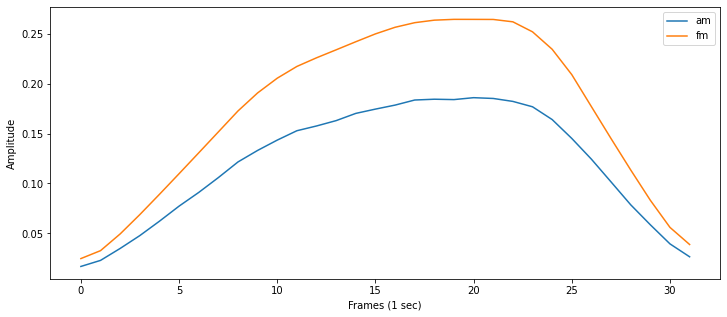

In [12]:
#@title Visualización de datos { run: "auto" }
# Tipos de visualización:

#*   **F0:** Nos permite visualizar la fundamental de los grupos de sonidos para ubicar en que rango frecuencial se encuentran.
#*   **Histogram:** Nos da el historial de cuantos audios de cada grupo tenemos en nuestra base de datos.
#*   **Spectogram:** Nos permite visualizar una muestra aleatoria de cada grupo.
#* **envelopegram:** Nos permite visualizar una envolvente que promedia el grupo de sonidos completo.

dframes = []
for key, value in update_sliders.items():
  dframes.append(DATA[DATA['gid'] == key].reset_index().iloc[0: value.value])
  #print(key + str(value))
  DATA_filt = pd.concat(dframes).reset_index()
audiotracks = dict(zip(DATA_filt['id'], DATA_filt['id'].index))
DATA_filt
'''
def id_gen(df):
  try:
    ids = list(df['id'])
    return ids
  except:
    dframes = []
    for key, value in update_sliders.items():
      dframes.append(DATA[DATA['gid'] == key].reset_index().iloc[0: value.value])
      #print(key + str(value))
      DATA_filt = pd.concat(dframes).reset_index()
    audiotracks = dict(zip(DATA_filt['id'],DATA_filt['id'].index))
    return DATA_filt
'''


ids = list(DATA_filt['id'])

#ids = id_gen(DATA_filt)

audio_viz = 'Envelopegram' #@param ['PCA','F0', 'Histogram','Spectral centroid', 'Envelopegram']
#fig, ax = plt.subplots()
plt.figure(figsize = [12,5])
#fig.set_size_inches([12,5])

if audio_viz == 'Histogram':
  ax = plt.subplot(1,1,1)
  ax = DATA_filt['gid'].hist()
  ax.set_xlabel("Synth type")
  ax.set_ylabel(" # of observations")
  plt.show()
if audio_viz == 'F0':
  ax = plt.subplot(1,1,1)
  ax.set_xlabel("Fundamental")
  ax.set_ylabel("Groups")
  #ax.scatter(DATA_filt['f0'], DATA_filt['f0'], linestyle = '--')
  ax.scatter(x = DATA_filt['f0'],y = DATA_filt['gid'], cmap= 10)
  plt.show()
if audio_viz == 'PCA':
  ax = plt.subplot(1,1,1)
  pca = PCA(n_components= 2)
  X_PCA = pca.fit_transform(np.vstack(DATA_filt['fft']))
  print('variance: ')
  print(pca.explained_variance_ratio_)
  counter = 0 
  cu = 0

  for s_values in update_sliders.items():
    if s_values[1].value != 0:
  #for key, value in update_sliders.items():
    #print(key,value)
      ax.scatter(X_PCA[counter: counter + s_values[1].value, 0],
                X_PCA[counter: counter + s_values[1].value, 1],
                cmap= 10, 
                label = key)
      counter += s_values[1].value
      cu += 1
    ax.set_title('PCA')
    plt.xticks([])
    plt.yticks([])
    ax.legend(DATA_filt['gid'].drop_duplicates())

if audio_viz == 'Spectral centroid':
  ax = plt.subplot(1,1,1)
  ax.set_xlabel("Frequencies")
  ax.set_ylabel("Groups")
  ax.scatter(x = DATA_filt['sc'],y = DATA_filt['gid'], cmap= 10)
  plt.show()
  
if audio_viz == 'Envelopegram':
  ax = plt.subplot(1, 1, 1)
  clases = list(DATA_filt['gid'].drop_duplicates())
  for clase in clases:
      ax.plot(DATA_filt[DATA_filt['gid'] == clase]['rms'].mean())
    
  ax.legend(clases)
  ax.set_ylabel('Amplitude')
  ax.set_xlabel('Frames (1 sec)')

  #plt.show()
  

# *ENTRENAMIENTO* 🤖

In [13]:
#@title Entrenamiento del modelo

from google.colab import files
##standarizacion de datos

data = np.vstack(DATA_filt['data'])
mu_wave = np.mean(data, axis= 1)[...,np.newaxis]
max_wave = np.max(data, axis=1)[...,np.newaxis]
Xw = (data- mu_wave)/max_wave
Xw = Xw[...,np.newaxis][...,np.newaxis]

referencia_1 = 'Nuevo modelo' #@param ['Nuevo modelo','Preentrenado']
Epocas = 10 #@param {type:"slider", min:10, max:10000, step:1}
batches = 5 #@param {type: "integer"}
lr = 0.00008 #@param {type: "slider", min:0.00001, max: 0.0001, step:0.00001}

warm_up_iters = 1000 
optimizer = tf.keras.optimizers.Adam(lr, clipvalue=0.5)
if referencia_1 == 'Preentrenado': 
  original_dim = (16000, 1, 1)
  encoder_inputs = keras.Input(original_dim)  
  encoder_pretrained = tf.keras.models.load_model('/content/encoder2_cdmx',compile = False)
  decoder_pretrained = tf.keras.models.load_model('/content/decoder2_cdmx',compile = False)
  outpt = decoder_pretrained(encoder_pretrained(encoder_inputs)[2])
  vae = Model(inputs=encoder_inputs, outputs=outpt, name='VAE-Model')
  vae.compile(optimizer= optimizer,loss = 'mean_squared_error')
  tr_logs = vae.fit(Xw, Xw, shuffle = True, batch_size= batches, epochs= Epocas, verbose = 1)
  latent =  encoder_pretrained.predict(Xw[0:])

if referencia_1 == 'Nuevo modelo': 
  original_dim = (16000, 1, 1)
  encoder_inputs = keras.Input(original_dim)  
  encoder_pretrained = tf.keras.models.load_model('/content/vanilla_encoder',compile = False)
  decoder_pretrained = tf.keras.models.load_model('/content/vanilla_decoder',compile = False)
  outpt = decoder_pretrained(encoder_pretrained(encoder_inputs)[2])
  vae = Model(inputs= encoder_inputs, outputs= outpt, name='VAE-Model')
  vae.compile(optimizer= optimizer,loss = 'mean_squared_error')
  tr_logs = vae.fit(Xw, Xw, shuffle = True, batch_size= batches, epochs= Epocas, verbose = 1)
  latent =  encoder_pretrained.predict(Xw[0:])
else:
  print('.....')
  '''
  new_model = tf.keras.models.load_model('/content/model_vae')
  new_model.compile(optimizer= optimizer,loss = 'mean_squared_error')
  tr_logs = new_model.fit(Xw, Xw, shuffle = True, batch_size= batches, epochs= Epocas, verbose = 1)
  '''

Epoch 1/10
4/4 [==============================] - 14s 109ms/step - loss: 0.1836
Epoch 2/10
4/4 [==============================] - 0s 34ms/step - loss: 0.1835
Epoch 3/10
4/4 [==============================] - 0s 32ms/step - loss: 0.1834
Epoch 4/10
4/4 [==============================] - 0s 32ms/step - loss: 0.1834
Epoch 5/10
4/4 [==============================] - 0s 32ms/step - loss: 0.1834
Epoch 6/10
4/4 [==============================] - 0s 31ms/step - loss: 0.1834
Epoch 7/10
4/4 [==============================] - 0s 30ms/step - loss: 0.1833
Epoch 8/10
4/4 [==============================] - 0s 29ms/step - loss: 0.1834
Epoch 9/10
4/4 [==============================] - 0s 32ms/step - loss: 0.1833
Epoch 10/10
1/1 [==============================] - 0s 219ms/step


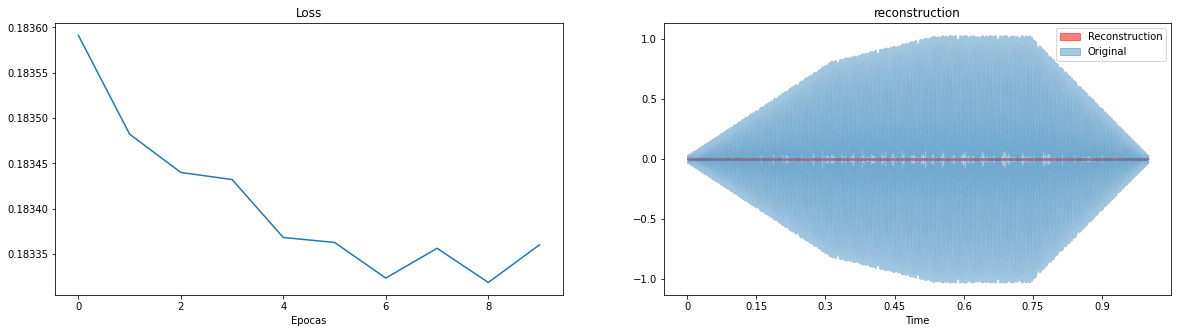

In [18]:
#@title Evaluación del modelo
#una visualización donde se vea la curva del modelo junto a la recunstruccion

def latent_vectorize(audio_id,df,audio_list):
  audio_idx = list(df[df['id'] == audio_id].index)[0]
  latent_gen = encoder_pretrained.predict(audio_list[audio_idx:], verbose = 0)
  return latent_gen[0]

def latent_reconstruction(latent_gen):
  recons = decoder_pretrained.predict(latent_gen[0:], verbose = 0)
  recons= recons[0].flatten()
  return recons


def latent_search(audio_id, df, audio_list):
  '''function that retrieves the correct audio representation in the latent space'''
  try:
    latent_gen = latent_vectorize(audio_id,df,audio_list)
    recons = latent_reconstruction(latent_gen)
    return latent_gen, recons
  except TypeError:
    print("audio input must be a valid string")
    
def latent_inter(audio_a, audio_b, step = 100, porcentaje = 50, audio_list = Xw):
  'crea 100 vectores pensados en % y reconstruye'
  if step == 1:
    listas = np.linspace(audio_a, audio_b, step)
    res = latent_reconstruction(listas[porcentaje-1:])
  else:
    listas = np.linspace(audio_a, audio_b, step)
    res = latent_reconstruction(listas[porcentaje-1:])
  return res

'''
def latent_search(audio_id, df, audio_list):
 ''''''function that retrieves the correct audio representation in the latent space''''''
  try:
    audio_idx = list(df[df['id'] == audio_id].index)[0]
    latent_gen = encoder_pretrained.predict(audio_list[audio_idx:])
    recons = decoder_pretrained.predict(latent_gen[0][0:])
    recons= recons[0].flatten()
    return latent_gen, recons
  except TypeError:
    print("audio input must be a valid string")
'''

def gps_latent(dic_tracks, df, data):
  '''search all track ids position in the latent space in an ''orderly fashion'' '''
  res_latent = []
  for key in dic_tracks.keys():
    res_latent.append(latent_search(key, df, data)[0])
  return res_latent

all_tracks_latent = gps_latent(audiotracks, DATA_filt, Xw)


track = random.choices(ids)[0]
fig, ax = plt.subplots(1,2)
fig.set_figwidth(20)
fig.set_figheight(5)
ax[0].plot(tr_logs.history['loss'])
librosa.display.waveshow(latent_search(track, DATA_filt, Xw)[1], sr=16000, color='r', alpha=0.5, ax=ax[1], label='Reconstruction')
librosa.display.waveshow(Xw[audiotracks[track]].flatten(), sr=16000, alpha=0.4, ax=ax[1], label='Original')
IPython.display.display(IPython.display.Audio(Xw[audiotracks[track]].flatten(), rate = sr16k))
IPython.display.display(IPython.display.Audio(latent_search(track, DATA_filt, Xw)[1], rate = sr16k))


ax[1].legend()
ax[0].set_xlabel("Epocas")
ax[0].set_title('Loss')
ax[1].set_title('reconstruction')
fig.show()

# *GENERACIÓN* 🎛

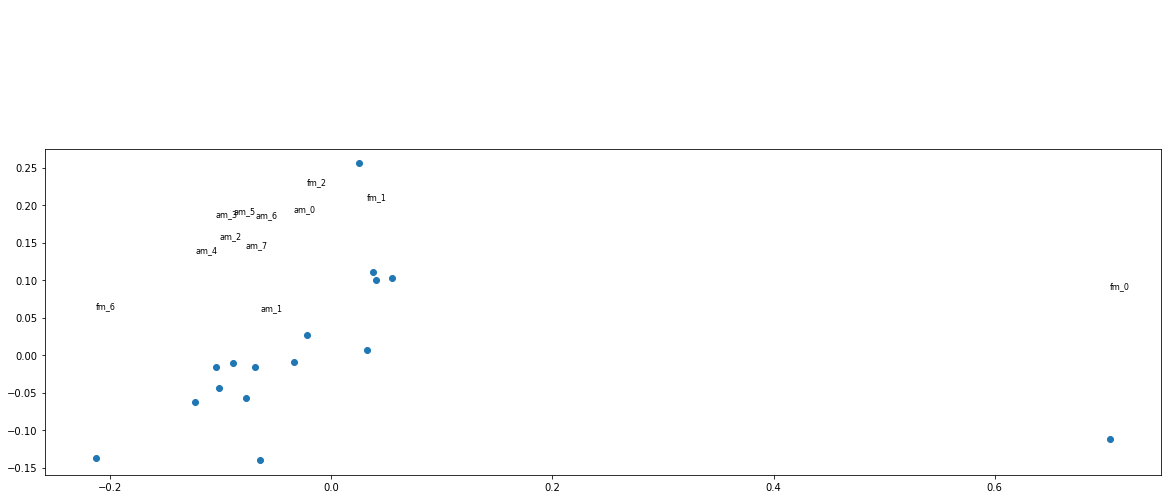

In [23]:
#@title EXPLORACIÓN DE DATOS
#%matplotlib notebook
from IPython.display import display
import ipywidgets as widgets
import matplotlib.pyplot as plt
plt.figure(figsize = [20,6])

def setup_ui(df):
    
    out2 = widgets.Output()
    with out2:
        display(df)
    return out2
 
def viz_ui():
    out2 = widgets.Output()
    with out2:
      try:
        update = list(zip(DATA_filt['gid'],ids, np.vstack(all_tracks_latent)))
        pca_df = pd.DataFrame(data= update)
        pca = PCA(n_components= 2)
        latent_pca = pca.fit_transform(np.vstack(pca_df[2]))
        plt.scatter(latent_pca[0:, 0], latent_pca[0: ,1])
        for idx, id in enumerate(pca_df[1]):
                  plt.annotate(id,(latent_pca[idx][0], latent_pca[idx][1]+ 0.2), fontsize= 8)
      except TypeError:
        print("No olvides evaluar el modelo")
    return out2  


df_display = HBox(children = [setup_ui(DATA_filt.loc[:,'gid':])])
latent_display = HBox(children = [viz_ui()])

tab_latent = widgets.Tab()
tab_latent.children = [latent_display, df_display]
tab_latent.set_title(0,"latent space")
tab_latent.set_title(1,"table")
tab_latent

1/1 [==============================] - 1s 705ms/step


Output()

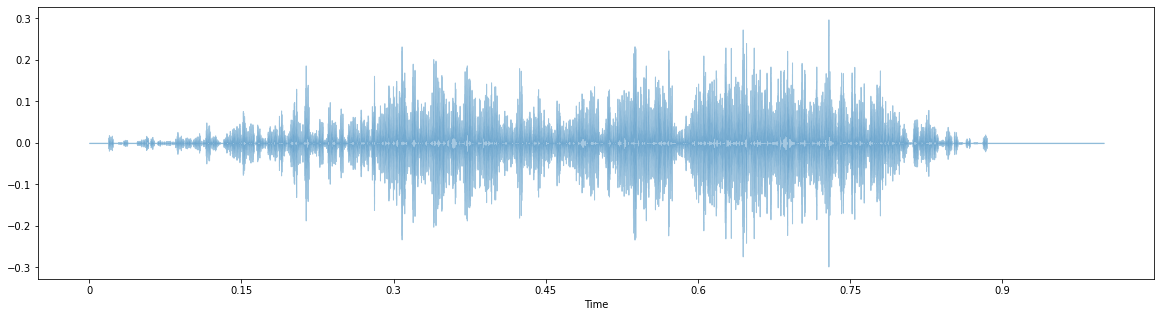

In [ ]:
#@title Exploración y generación { run: "auto" }
#@markdown Escribe el nombre del id

import soundfile as sf
from google.colab import files
import os

audio_id = 'fm_2' #@param {type:"string"}
audio_id2 = 'fm_3' #@param {type:"string"}
gen_c = 0
porcentaje_de_cambio = 5 #@param {type:"slider", min:1, max:10, step:1}
fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(5)

def resample_by_interpolation(signal, input_fs, output_fs):

    scale = output_fs / input_fs
    # calculate new length of sample
    n = round(len(signal) * scale)
    resampled_signal = np.interp(
        np.linspace(0.0, 1.0, n, endpoint=False),  # where to interpret
        np.linspace(0.0, 1.0, len(signal), endpoint=False),  # known positions
        signal,  # known data points
    )
    return resampled_signal


idx = list(DATA_filt[DATA_filt['id'] == audio_id].index)[0]
idx2 = list(DATA_filt[DATA_filt['id'] == audio_id2].index)[0]
audio_a = all_tracks_latent[0][idx]
audio_b = all_tracks_latent[0][idx2]
inter = latent_inter(audio_a, audio_b, 10, porcentaje_de_cambio)

librosa.display.waveshow(inter, sr=16000, alpha=0.4, label='Original')
IPython.display.display(IPython.display.Audio(resample_by_interpolation(inter, 16000, 44100), rate = 44100))


#
b_names = ['Save', 'Download tracks']
button = [widgets.Button(description= i)for i in b_names]

botons = HBox(children = button)
output = widgets.Output()

def saved(b):
  # Display the message within the output widget.
  with output:
    #print("Button clicked.")
    resample_by_interpolation(inter, 16000, 44100)
    sf.write('aciml_inter_'+ audio_id + audio_id2 +'.wav',inter, 44100)


def on_button_clicked(b):
  # Display the message within the output widget.
  with output:
    #print("Button clicked.")
    for i in os.listdir('/content/'):
      #print(i)
      if i.startswith("aciml_inter"):
        files.download(i)

button[0].on_click(saved)
button[1].on_click(on_button_clicked)

display(botons, output)



******
*
*
*
*
*
*
*
*
*
*
*
*




******

******
*
*
*
*
*
*
*
*
*
*
*
*




******

******
*
*
*
*
*
*
*
*
*
*
*
*




******